<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/diffusion/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
diffusion_path = '/content/drive/My Drive/IML Final Project/diffusion/'
print(os.listdir(diffusion_path))

['256x256_diffusion.pt']


# Dependency

In [ ]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers transformers accelerate torch torchvision --quiet

Load model from pre-trained repo

In [ ]:
# Import libraries
import os
import pickle
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torch.utils.data import DataLoader, Dataset
from google.colab import files
from google.colab import drive
from torchvision import transforms

In [ ]:
def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

# Attack data loading

In [ ]:
drive.mount('/content/drive')
path_data = '/content/drive/My Drive/IML Final Project/diffusion/'
def load_pkl(file_path):
  with open(file_path, 'rb') as f:
    data = pickle.load(f)
  return data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
train_attack_dataset = load_pkl(os.path.join(path_data, 'train_attack_dataset.pkl'))
train_swap_attack_dataset = load_pkl(os.path.join(path_data, 'train_swap_attack_dataset.pkl'))
val_attack_dataset = load_pkl(os.path.join(path_data, 'val_attack_dataset.pkl'))
val_swap_attack_dataset = load_pkl(os.path.join(path_data, 'val_swap_attack_dataset.pkl'))

In [ ]:
# Sample Inspection
print(next(iter(train_attack_dataset))[0].shape)
print(next(iter(train_swap_attack_dataset))[0].shape)
print(next(iter(val_attack_dataset))[0].shape)
print(next(iter(val_swap_attack_dataset))[0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True)
pipeline.to(device)

device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
attacked_img =  next(iter(train_attack_dataset))[0]
attacked_img


tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652, -1.2788,  0.0569],
         [ 2.2489,  1.3070,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.2513, -0.2513, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.3369, -0.5596, -0.3198,  ..., -1.5528, -0.8849, -0.8849],
         [-0.3369, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155, -1.1779,  0.8179],
         [ 0.3102,  1.4832,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [-0.1275, -0.1275,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [-0.2150,  0.0476, -0.1975,  ..., -1.5805, -0.9678, -0.9678],
         [-0.2150,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

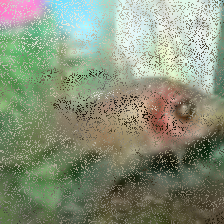

In [ ]:
display(tensor_to_pil_image(attacked_img))

In [ ]:
image = pipeline(prompt="Purify the image from noise", image=attacked_img)
image

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4DFB4E5000>], nsfw_content_detected=[False])

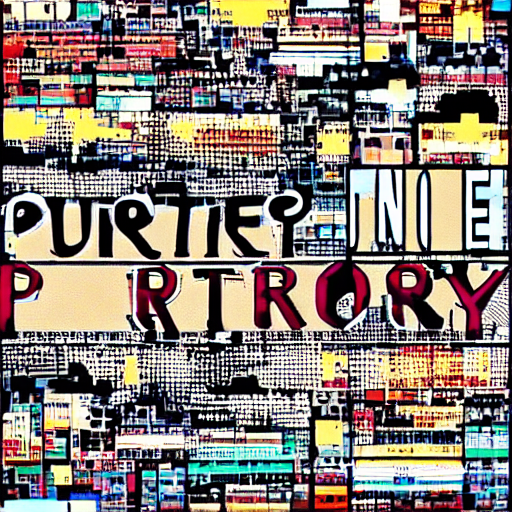

In [ ]:
image.images[0]

In [ ]:
# Create a directory to save purified images
purified_dir = "purified_images"
os.makedirs(purified_dir, exist_ok=True)
purified_images = []
purified_images.append(image.images[0])

# Save each purified image
img_filename = f"purified_image_{len(purified_images)}.png"
image.images[0].save(os.path.join(purified_dir, img_filename))

# Guided Diffusion

In [ ]:
diffusion_path = '/content/drive/My Drive/IML Final Project/diffusion/'
print(os.listdir(diffusion_path))

['256x256_diffusion.pt', 'val_swap_attack_dataset.pkl', 'train_swap_attack_dataset.pkl', 'train_attack_dataset.pkl', 'val_attack_dataset.pkl', 'Test.ipynb']


In [ ]:
import torch.nn as nn

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # Define layers here based on the original architecture
        # Example:
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Instantiate the model
diffusion_model = DiffusionModel()

model_path = os.path.join(diffusion_path, '256x256_diffusion.pt')
state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
diffusion_model.load_state_dict(state_dict)
diffusion_model = diffusion_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
diffusion_model.eval()
print("Model loaded and ready for inference.")

<ipython-input-43-9f5b9c73ac71>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_avail

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.06 GiB. GPU 0 has a total capacity of 14.75 GiB of which 81.06 MiB is free. Process 4886 has 14.67 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 153.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Load the diffusion model
def load_diffusion_model(model_path):
    model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model

In [ ]:
# Load the diffusion model
model_path = os.path.join(diffusion_path, '256x256_diffusion.pt')
diffusion_model = load_diffusion_model(model_path)
print("Model loaded successfully.")

<ipython-input-37-f5729c64af93>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available()

Model loaded successfully.


In [ ]:
# Process images using the diffusion model
def denoise_image(model, image_tensor):
    with torch.no_grad():
        denoised_image = model(image_tensor)
    return denoised_image
processed_images = [next(iter(train_attack_dataset))[0]]
# Create a directory to save purified images
purified_dir = "purified_images"
os.makedirs(purified_dir, exist_ok=True)

# Batch process images
for idx, img in enumerate(processed_images):

    # Denoise the image
    denoised_image_tensor = denoise_image(diffusion_model, img)

    # Convert tensor back to PIL image
    denoised_image = ToPILImage()(denoised_image_tensor.squeeze(0).cpu())

    # Save the purified image
    img_filename = f"purified_image_{idx + 1}.png"
    denoised_image.save(os.path.join(purified_dir, img_filename))

TypeError: 'collections.OrderedDict' object is not callable